In [53]:
import os
import cv2
import numpy as np
from PIL import Image
import imagehash
from collections import defaultdict
import shutil
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
DATASET_DIR = './brain_tumor_dataset'
OUTPUT_DIR = 'brain_tumor_data_preprocessed'
# Data Quality Checks
SIMILARITY_THRESHOLD = 5
Z_SCORE_THRESHOLD = 3.0
LOW_VARIANCE_THRESHOLD = 10
# Image Preprocessing
TARGET_SIZE = (224, 224)
CROP_TO_SQUARE_RATIO = 1.1 

In [51]:
def preprocess_dataset():
    print("Starting data preprocessing pipeline.\n")
    in_memory_images = []
    print("Loading all images into memory")
    for class_name in ['yes', 'no']:
        class_dir = os.path.join(DATASET_DIR, class_name)
        if not os.path.isdir(class_dir):
            print(f"Warning: Directory not found for class '{class_name}'. Skipping.")
            continue
        
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(class_dir, filename)
                try:
                    image = cv2.imread(file_path)
                    if image is not None:
                        in_memory_images.append({
                            'path': file_path,
                            'class': class_name,
                            'image': image
                        })
                    else:
                        print(f"  - Warning: Could not read (corrupted?) file: {file_path}")
                except Exception as e:
                    print(f"  - Warning: Error loading {file_path}: {e}")
    print(f"  - Loaded {len(in_memory_images)} images successfully.\n")

    if not in_memory_images:
        print("  - No images to process. Skipping duplicate check.\n")
        images_after_dedupe = []
    else:
        # Compute perceptual hashes for all images
        image_hashes = {}
        for data in in_memory_images:
            try:
                # Convert OpenCV BGR to RGB for Pillow/imagehash
                image_rgb = cv2.cvtColor(data['image'], cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(image_rgb)
                image_hashes[data['path']] = imagehash.phash(pil_image)
            except Exception as e:
                print(f"  - Warning: Could not hash {data['path']}: {e}")

        images_by_path = {data['path']: data for data in in_memory_images}
        
        # Find all pairs of visually similar images
        duplicate_pairs = []
        paths = list(image_hashes.keys())
        for i in range(len(paths)):
            for j in range(i + 1, len(paths)):
                path1 = paths[i]
                path2 = paths[j]
                distance = image_hashes[path1] - image_hashes[path2]
                if distance <= SIMILARITY_THRESHOLD:
                    duplicate_pairs.append((path1, path2))

        # Use a graph to find connected components of duplicates.
        # This should group images like A~B and B~C into a single set {A, B, C}.
        G = nx.Graph()
        G.add_edges_from(duplicate_pairs)
        connected_components = list(nx.connected_components(G))

        paths_to_remove = set()

        # For each group of duplicates, find the one with the highest resolution
        for component in connected_components:
            if len(component) > 1:  # A group of <= 2 similar images
                best_path = ""
                max_resolution = -1
                
                # Find the "best" image (ie. largest) in the component to ensure we lose as little data as possible in image resize
                for path in component:
                    image_data = images_by_path[path]['image']
                    resolution = image_data.shape[0] * image_data.shape[1]
                    if resolution > max_resolution:
                        max_resolution = resolution
                        best_path = path
                
                for path in component:
                    if path != best_path:
                        paths_to_remove.add(path)
        images_after_dedupe = [data for data in in_memory_images if data['path'] not in paths_to_remove]
    
    num_duplicates = len(in_memory_images) - len(images_after_dedupe)
    print(f"  - Found and marked {num_duplicates} duplicate images for removal.\n")
    
    print("Checking for outliers.")
    # Z-Score for brightness
    brightness_values = []
    for data in images_after_dedupe:
        # Convert to grayscale to calculate brightness
        gray_image = cv2.cvtColor(data['image'], cv2.COLOR_BGR2GRAY)
        brightness_values.append(np.mean(gray_image))
    
    brightness_values = np.array(brightness_values)
    mean_brightness = np.mean(brightness_values)
    std_brightness = np.std(brightness_values)
    
    outliers_to_remove = set()
    
    for i, data in enumerate(images_after_dedupe):
        # Check Z-score
        z_score = (brightness_values[i] - mean_brightness) / std_brightness
        if abs(z_score) > Z_SCORE_THRESHOLD:
            outliers_to_remove.add(data['path'])
            print(f"  - Outlier (Z-Score): {data['path']} (Z-Score: {z_score:.2f})")
            continue
            
        # Check blank images
        gray_image = cv2.cvtColor(data['image'], cv2.COLOR_BGR2GRAY)
        if np.std(gray_image) < LOW_VARIANCE_THRESHOLD:
            outliers_to_remove.add(data['path'])
            print(f"  - Outlier (Low Variance): {data['path']}")

    images_after_outliers = [data for data in images_after_dedupe if data['path'] not in outliers_to_remove]
    num_outliers = len(images_after_dedupe) - len(images_after_outliers)
    print(f"  - Found and marked {num_outliers} outlier images for removal.\n")


    # Resize and write cleaned data to new directory
    print("Resizing and writing cleaned images to new directory")
    
    # Clear and create the output directories
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR) # Deletes the old directory and its contents
    os.makedirs(os.path.join(OUTPUT_DIR, 'yes'))
    os.makedirs(os.path.join(OUTPUT_DIR, 'no'))

    for data in images_after_outliers:
        try:
            image_to_process = data['image']
            h, w, _ = image_to_process.shape

            # Crop the image to a square if it's not already close to one
            if w > h * CROP_TO_SQUARE_RATIO:
                # Width is significantly larger, crop the center horizontally
                start_x = (w - h) // 2
                image_to_process = image_to_process[:, start_x:start_x + h]
            # Resize the (potentially cropped) image
            resized_image = cv2.resize(image_to_process, TARGET_SIZE, interpolation=cv2.INTER_AREA)
            
            # Create the new path and save the image
            filename = os.path.basename(data['path'])
            output_path = os.path.join(OUTPUT_DIR, data['class'], filename)
            cv2.imwrite(output_path, resized_image)
        except Exception as e:
            print(f"  - Warning: Could not save {data['path']}. Error: {e}")

    print(f"  - Successfully wrote {len(images_after_outliers)} preprocessed images to '{OUTPUT_DIR}'.\n")
    print("Pipeline finished successfully!")

In [36]:
def run_analytics(dataset_dir=DATASET_DIR):
    global_min_pixel = 255
    global_max_pixel = 0
    global_min_height_res = 99999
    global_min_width_res = 99999
    global_max_height_res = 0
    global_max_width_res = 0
    lower_bound_width = 0
    upper_bound_width = 0
    lower_bound_height = 0
    upper_bound_height = 0
    for root, dirs, files in os.walk(dataset_dir):
        for file_name in files:
            # Manual image type validation discovered 3 formats
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                if image is not None:
                    h, w = image.shape
                    global_min = min(global_min_pixel, np.min(image))
                    global_max = max(global_max_pixel, np.max(image))
                    global_max_height_res = max(global_max_height_res, np.max(h))
                    global_max_width_res = max(global_max_width_res, np.max(w))
                    global_min_height_res = min(global_min_height_res, np.min(h))
                    global_min_width_res = min(global_min_width_res, np.min(w))
                    if w < 224:
                        lower_bound_width+=1
                    else:
                        upper_bound_width+=1
                    if h < 224:
                        lower_bound_height+=1
                    else:
                        upper_bound_height+=1
                else:
                    print(f"Warning: Could not read image at {image_path}")
    print(f"Overall Minimum Pixel Intensity: {global_min}")
    print(f"Overall Maximum Pixel Intensity: {global_max}")
    print(f"Overall Maximum Height: {global_max_height_res}")
    print(f"Overall Minimum Height: {global_min_height_res}")
    print(f"Overall Maximum Width: {global_max_width_res}")
    print(f"Overall Minimum Width: {global_min_width_res}")
    print(f"Height Bounds: {lower_bound_height} : {upper_bound_height}")
    print(f"Width Bounds: {lower_bound_width} : {upper_bound_width}")

In [56]:
def get_stats(dataset_dir=DATASET_DIR):
    stats_list = []
    print(f"Starting to scan images in '{dataset_dir}'...")

    for class_name in ['yes', 'no']:
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            print(f"Warning: Directory not found for class '{class_name}'. Skipping.")
            continue

        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(class_dir, filename)
                try:
                    # Get file size
                    size_kb = os.path.getsize(file_path) / 1024

                    # Load image with OpenCV
                    image = cv2.imread(file_path)
                    if image is None:
                        print(f"Warning: Could not read image file: {file_path}")
                        continue

                    # Get dimensions
                    h, w, _ = image.shape

                    # Calculate aspect ratio
                    aspect_ratio = w / h if h > 0 else 0

                    # Calculate brightness (mean of grayscale version)
                    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    brightness = np.mean(gray_image)

                    stats_list.append({
                        'class': class_name,
                        'path': file_path,
                        'width': w,
                        'height': h,
                        'aspect_ratio': aspect_ratio,
                        'size_kb': size_kb,
                        'brightness': brightness
                    })

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    
    print(f"Scan complete. Processed {len(stats_list)} images.")
    return pd.DataFrame(stats_list)

def plot_distributions(df):
    if df.empty:
        print("DataFrame is empty. No plots to generate.")
        return

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle('Exploratory Data Analysis of Brain Scan Images', fontsize=20)

    sns.histplot(data=df, x='width', color="blue", label='Width', kde=True, ax=axes[0, 0])
    sns.histplot(data=df, x='height', color="red", label='Height', kde=True, ax=axes[0, 0], alpha=0.6)
    axes[0, 0].set_title('Distribution of Image Dimensions')
    axes[0, 0].legend()

    sns.histplot(data=df, x='aspect_ratio', kde=True, ax=axes[0, 1], color='darkgreen')
    axes[0, 1].axvline(1.0, color='r', linestyle='--', label='Square (1.0)')
    axes[0, 1].set_title('Distribution of Aspect Ratios (Width / Height)')
    axes[0, 1].legend()

    sns.histplot(data=df, x='size_kb', kde=True, ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('Distribution of File Sizes (in KB)')

    sns.histplot(data=df, x='brightness', kde=True, ax=axes[1, 1], color='orange')
    axes[1, 1].set_title('Distribution of Average Image Brightness')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Overall Minimum Pixel Intensity: 0
Overall Maximum Pixel Intensity: 255
Overall Maximum Height: 1427
Overall Minimum Height: 168
Overall Maximum Width: 1920
Overall Minimum Width: 150
Height Bounds: 27 : 227
Width Bounds: 51 : 203
Starting to scan images in './brain_tumor_dataset'...
Scan complete. Processed 253 images.


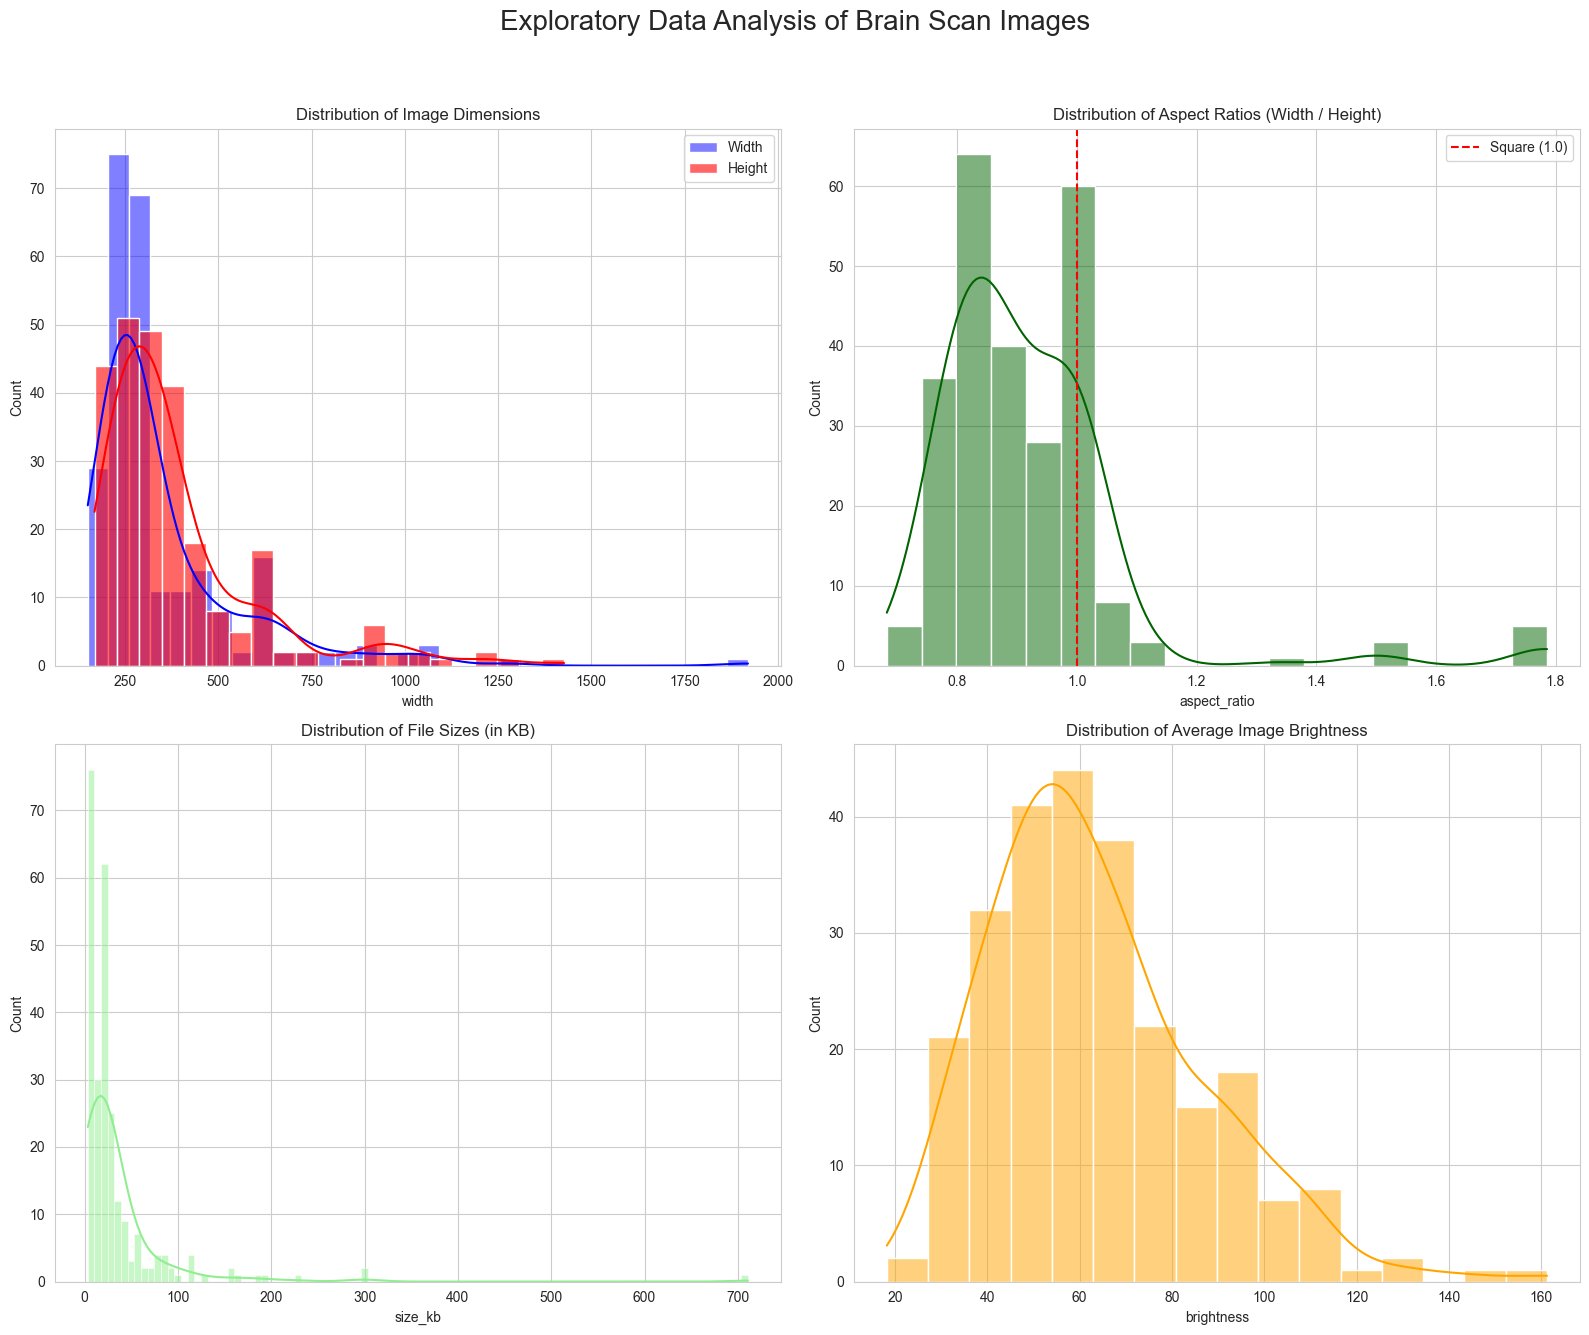

Starting data preprocessing pipeline.

Loading all images into memory
  - Loaded 253 images successfully.

  - Found and marked 47 duplicate images for removal.

Checking for outliers.
  - Outlier (Z-Score): ./brain_tumor_dataset\yes\Y147.JPG (Z-Score: 3.43)
  - Outlier (Z-Score): ./brain_tumor_dataset\no\No16.jpg (Z-Score: 4.18)
  - Found and marked 2 outlier images for removal.

Resizing and writing cleaned images to new directory
  - Successfully wrote 204 preprocessed images to 'brain_tumor_data_preprocessed'.

Pipeline finished successfully!
Overall Minimum Pixel Intensity: 0
Overall Maximum Pixel Intensity: 255
Overall Maximum Height: 224
Overall Minimum Height: 224
Overall Maximum Width: 224
Overall Minimum Width: 224
Height Bounds: 0 : 204
Width Bounds: 0 : 204
Starting to scan images in 'brain_tumor_data_preprocessed'...
Scan complete. Processed 204 images.


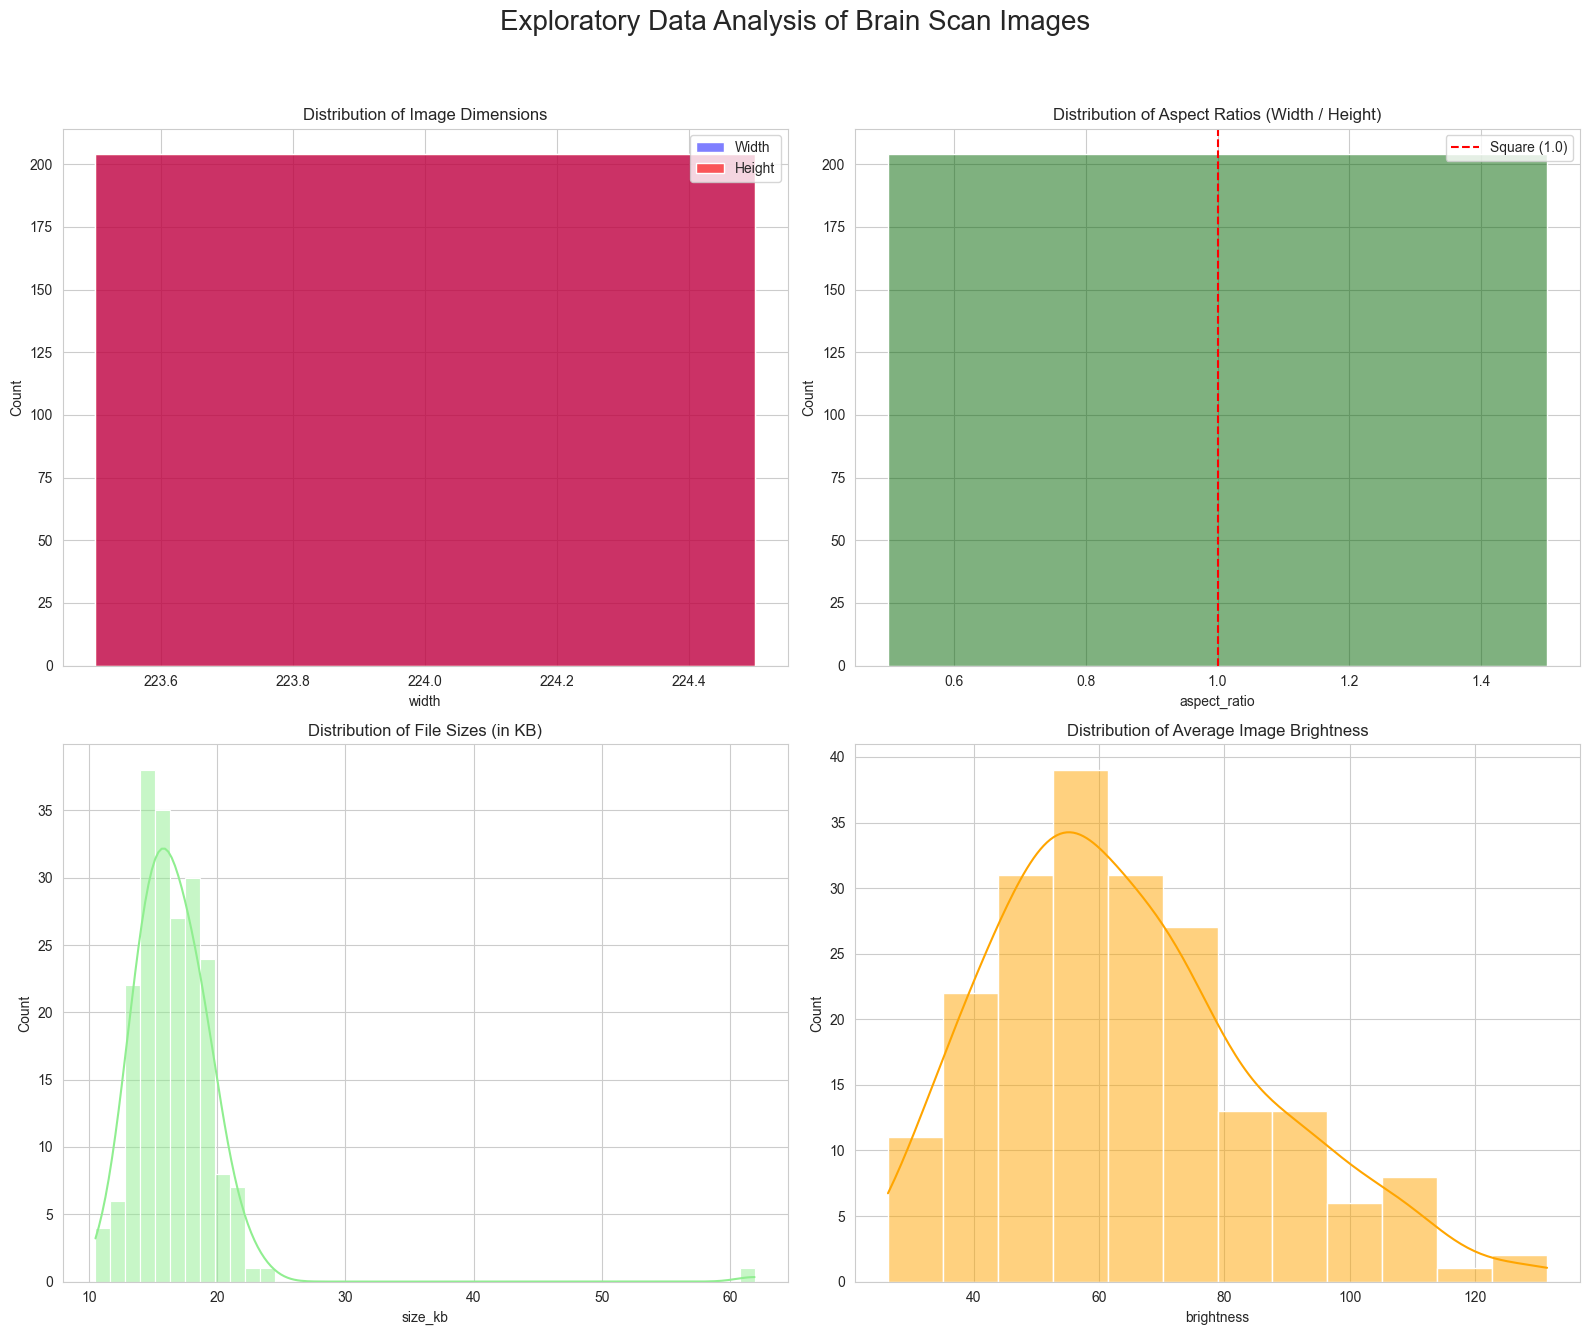

In [57]:
if __name__ == '__main__':
    run_analytics()
    plot_distributions(get_stats())
    preprocess_dataset()
    run_analytics(OUTPUT_DIR)
    plot_distributions(get_stats(OUTPUT_DIR))